In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("ok")


ok


In [2]:
try:
   df = pd.read_csv('koi_data.csv')
except:
   print("Falha ao abrir o banco de dados!")
else:
   print("Banco de dados aberto!")


Banco de dados aberto!


In [3]:
#Tipo de dado de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepoi_name        5202 non-null   object 
 1   koi_disposition   5202 non-null   object 
 2   koi_period        5202 non-null   float64
 3   koi_impact        5202 non-null   float64
 4   koi_duration      5202 non-null   float64
 5   koi_depth         5202 non-null   float64
 6   koi_ror           5202 non-null   float64
 7   koi_srho          5202 non-null   float64
 8   koi_prad          5202 non-null   float64
 9   koi_sma           5202 non-null   float64
 10  koi_incl          5202 non-null   float64
 11  koi_teq           5202 non-null   float64
 12  koi_insol         5202 non-null   float64
 13  koi_dor           5202 non-null   float64
 14  koi_max_sngle_ev  5202 non-null   float64
 15  koi_max_mult_ev   5202 non-null   float64
 16  koi_model_snr     5202 non-null   float64


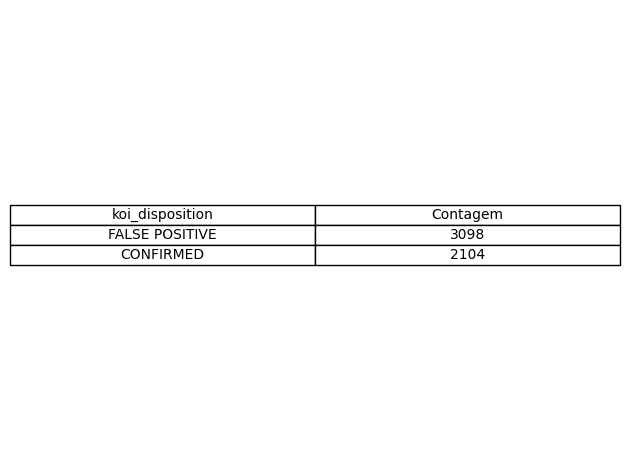

In [4]:
#Contagem de quantos CONFIRMED E FALSE POSITIVE tem NO DF

contagens = df.koi_disposition.value_counts()

# Criando a figura e o eixo
fig, ax = plt.subplots()

# Ocultando o eixo (opcional)
ax.axis('off')
ax.axis('tight')

# Convertendo para DataFrame para criar a tabela
table_data = contagens.reset_index()
table_data.columns = ['koi_disposition', 'Contagem']

# Criando a tabela
ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Ajustando o layout
fig.tight_layout()

# Exibindo a tabela
plt.show()

In [5]:
X = df.iloc[:, 2:].values  # Todas as colunas exceto a primeira (KOI ID) e a segunda (label)
Y = df.iloc[:, 1].values   # Segunda coluna (label) Koi Disposition, Confirmed, False Positive
      

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.70, shuffle = True, random_state = 0)
#train_size=0.70: Define a proporção dos dados que será usada para treinamento. 
#Aqui, 70% dos dados serão usados para o conjunto de treino e os 30% restantes para o conjunto de teste.
#shuffle=True: Indica que os dados devem ser embaralhados antes da divisão. 
#Isso é útil para garantir que a divisão seja aleatória e que os dados de treino e teste sejam representativos da distribuição geral dos dados.

In [7]:
# Normalizando os dados para garantir que todas as colunas tenham o mesmo intervalo de valores.
# Obs. A normalização garante que todos os features tenham a mesma importância.
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_train = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)
#X_test_scaled = scaler.transform(X_test)
#X_test = pd.DataFrame(X_test_scaled, index = X_test.index, columns = X_test.columns)
#print(y_train.value_counts())
#X_train

In [8]:
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machines': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Tree Boosting': GradientBoostingClassifier(),
    #'Multi-layer Perceptron': MLPClassifier()  # Aumentar o número de iterações
    'Multi-layer Perceptron': MLPClassifier(
        hidden_layer_sizes=(25,),
        activation='tanh',
        solver='adam',
        learning_rate_init=0.003
    )
}

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#Aqui, shuffle=True embaralha os dados antes de dividí-los, e random_state=42 garante que os resultados sejam reprodutíveis.

Naive Bayes: Acurácia média = 0.9166, Desvio padrão = 0.0111
Decision Tree: Acurácia média = 0.9435, Desvio padrão = 0.0064
k-Nearest Neighbors: Acurácia média = 0.8956, Desvio padrão = 0.0076
Support Vector Machines: Acurácia média = 0.9358, Desvio padrão = 0.0076
Random Forest: Acurácia média = 0.9706, Desvio padrão = 0.0057
Gradient Tree Boosting: Acurácia média = 0.9696, Desvio padrão = 0.0030
Multi-layer Perceptron: Acurácia média = 0.9489, Desvio padrão = 0.0074


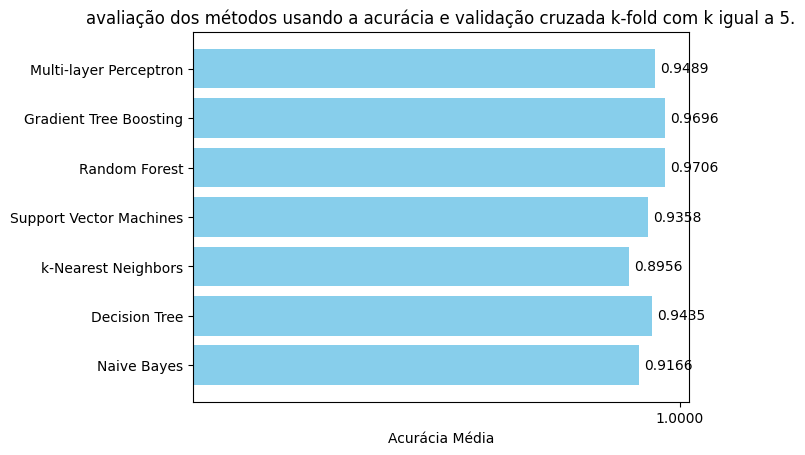

In [29]:
results = {}
for model_name, model in models.items():
    # Cria o pipeline com a normalização e o modelo
    pipeline = make_pipeline(StandardScaler(), model)
    
    # Executa a validação cruzada k-fold
    scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
    
    # Armazena a acurácia média
    print(f'{model_name}: Acurácia média = {scores.mean():.4f}, Desvio padrão = {scores.std():.4f}')
    results[model_name] = scores.mean()

# Criando o gráfico de barras para comparar as acurácias médias
# Criando o gráfico de barras para comparar as acurácias médias
fig, ax = plt.subplots()
model_names = list(results.keys())
mean_accuracies = list(results.values())

bars = ax.barh(model_names, mean_accuracies, color='skyblue')

# Adicionando marcações mais precisas no eixo x
ax.set_xlabel('Acurácia Média')
ax.set_title('avaliação dos métodos usando a acurácia e validação cruzada k-fold com k igual a 5.')

# Ajustando as marcações do eixo x
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='lower'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))

# Adicionando anotações para os valores máximos
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', va='center', ha='left')

plt.show()

In [30]:
def naive_bayes_experiment(X, Y, kf):
    model = GaussianNB()
    pipeline = make_pipeline(StandardScaler(), model)
    scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
    mean_accuracy = scores.mean()
    print(f'Naive Bayes: Acurácia média = {mean_accuracy:.4f}, Desvio padrão = {scores.std():.4f}')
    return mean_accuracy

naive_bayes_experiment(X, Y, kf)

Naive Bayes: Acurácia média = 0.9166, Desvio padrão = 0.0111


np.float64(0.9165718983226189)

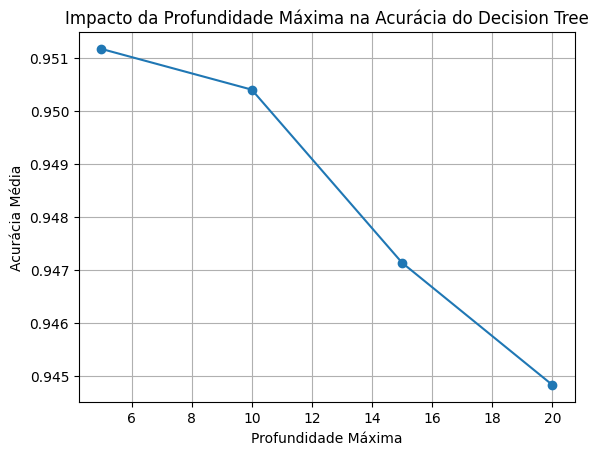

In [43]:
def decision_tree_experiment(X, Y, kf):
    depths = [None, 5, 10, 15, 20]
    accuracies = []

    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        pipeline = make_pipeline(StandardScaler(), model)
        scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
        accuracies.append(scores.mean())

    plt.plot(depths, accuracies, marker='o')
    plt.xlabel('Profundidade Máxima')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto da Profundidade Máxima na Acurácia do Decision Tree')
    plt.grid(True)
    plt.show()

decision_tree_experiment(X, Y, kf)

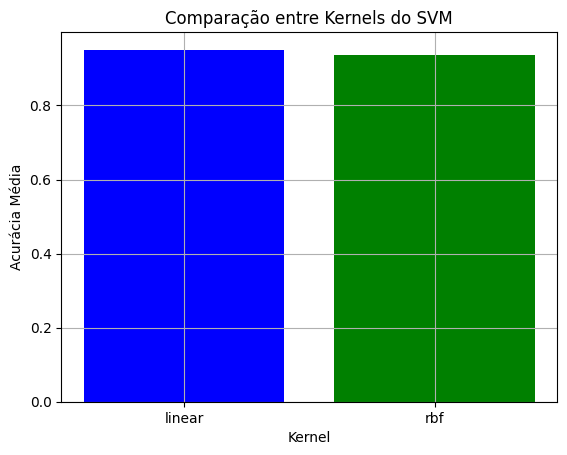

In [44]:
def svm_experiment(X, Y, kf):
    kernels = ['linear', 'rbf']
    accuracies = []

    for kernel in kernels:
        model = SVC(kernel=kernel, random_state=42)
        pipeline = make_pipeline(StandardScaler(), model)
        scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
        accuracies.append(scores.mean())

    plt.bar(kernels, accuracies, color=['blue', 'green'])
    plt.xlabel('Kernel')
    plt.ylabel('Acurácia Média')
    plt.title('Comparação entre Kernels do SVM')
    plt.grid(True)
    plt.show()

svm_experiment(X, Y, kf)


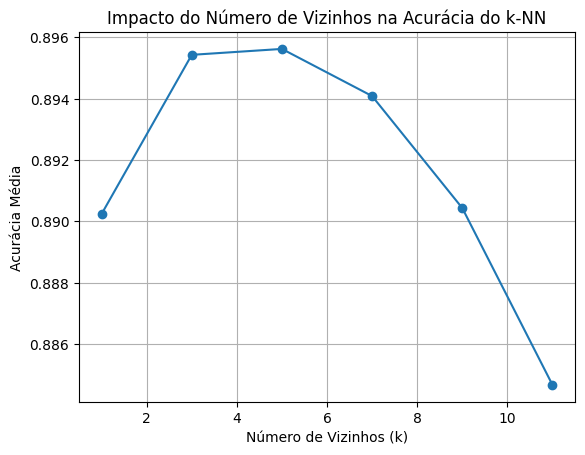

In [45]:
def knn_experiment(X, Y, kf):
    k_values = [1, 3, 5, 7, 9, 11]
    accuracies = []

    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        pipeline = make_pipeline(StandardScaler(), model)
        scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
        accuracies.append(scores.mean())

    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Número de Vizinhos (k)')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto do Número de Vizinhos na Acurácia do k-NN')
    plt.grid(True)
    plt.show()

knn_experiment(X, Y, kf)

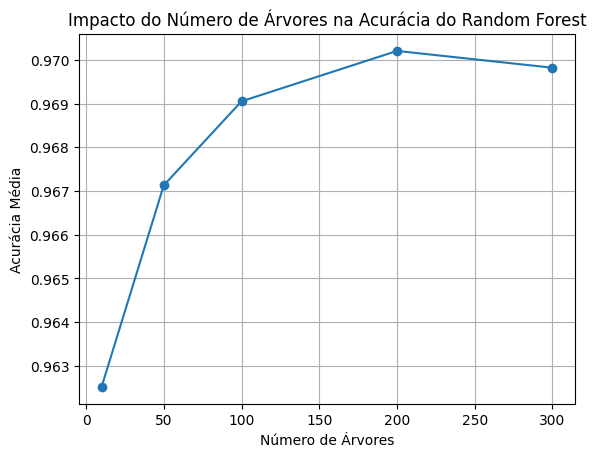

In [34]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_experiment(X, Y, kf):
    n_trees = [10, 50, 100, 200, 300]
    accuracies = []

    for n in n_trees:
        model = RandomForestClassifier(n_estimators=n, random_state=42)
        pipeline = make_pipeline(StandardScaler(), model)
        scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
        accuracies.append(scores.mean())

    plt.plot(n_trees, accuracies, marker='o')
    plt.xlabel('Número de Árvores')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto do Número de Árvores na Acurácia do Random Forest')
    plt.grid(True)
    plt.show()

random_forest_experiment(X, Y, kf)

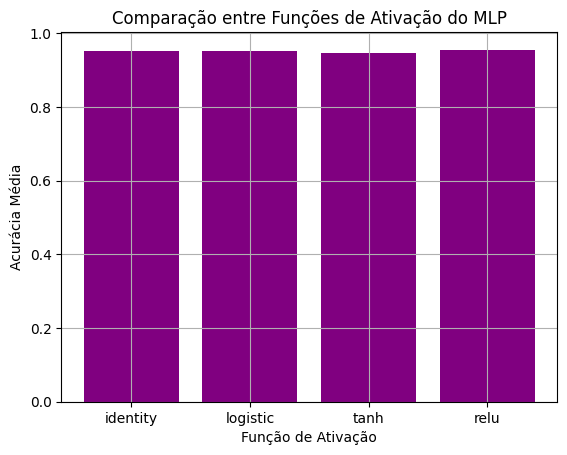

In [35]:
def mlp_experiment(X, Y, kf):
    activations = ['identity', 'logistic', 'tanh', 'relu']
    accuracies = []

    for activation in activations:
        model = MLPClassifier(
            hidden_layer_sizes=(25,),
            activation=activation,
            solver='adam',
            learning_rate_init=0.003,
            max_iter=1000,
            random_state=42
        )
        pipeline = make_pipeline(StandardScaler(), model)
        scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
        accuracies.append(scores.mean())

    plt.bar(activations, accuracies, color='purple')
    plt.xlabel('Função de Ativação')
    plt.ylabel('Acurácia Média')
    plt.title('Comparação entre Funções de Ativação do MLP')
    plt.grid(True)
    plt.show()

mlp_experiment(X, Y, kf)